In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim import SGD
import math
import random
import tqdm.notebook as tq
import time
import gc
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
data_path = Path("/", "gdrive", "My Drive", "Altum_Age_Dataset", "/gdrive/MyDrive/Altum_Age_Dataset/large_dataset.pkl")
def clean_data(df):
    return df[df.age > 0]
raw_dataframe = pd.read_pickle("/gdrive/MyDrive/Altum_Age_Dataset/large_dataset.pkl")
clean_df = clean_data(raw_dataframe)
clean_df.shape # (3030, 27582)
from sklearn.decomposition import PCA
pca = PCA(n_components=1024, whiten = False)
train_df, validate_df, test_df = np.split(clean_df.sample(frac=1, random_state=1), [int(.8*len(clean_df)), int(.9*len(clean_df))])
train_ages = train_df['age'].astype('float64')
val_ages = validate_df['age'].astype('float64')
test_ages = test_df['age'].astype('float64')
no_label = clean_df.drop(columns=["age"])
compressed = pd.DataFrame(pca.fit_transform(no_label))
d1,d2 = compressed.shape
c = np.array(compressed)
b = np.zeros((d1,d2+1))
b[:,:-1] = c
b[:,-1] = np.array(clean_df["age"])
train, validate, test = np.split(compressed.sample(frac=1, random_state=1), [int(.8*len(clean_df)), int(.9*len(clean_df))])
train.shape, validate.shape, test.shape

((4448, 1024), (556, 1024), (556, 1024))

In [5]:
compressed=(compressed-compressed.mean())/compressed.std()

In [6]:
SEED=1

In [7]:
train, validate, test = np.split(compressed.sample(frac=1, random_state=SEED), [int(.8*len(clean_df)), int(.9*len(clean_df))])
train.shape, validate.shape, test.shape

((4448, 1024), (556, 1024), (556, 1024))

In [8]:
train_df, validate_df, test_df = np.split(clean_df.sample(frac=1, random_state=SEED), [int(.8*len(clean_df)), int(.9*len(clean_df))])
train_ages = train_df['age'].astype('float64')
val_ages = validate_df['age'].astype('float64')
test_ages = test_df['age'].astype('float64')

In [9]:
import numpy as np
import pandas as pd


from sklearn import svm, linear_model, ensemble
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit

import gc

import math

from IPython.display import clear_output


import os

import matplotlib

import random

# from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

# import neural_structured_learning as nsl

# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Normalization, Activation, InputLayer, ActivityRegularization, GaussianDropout, GaussianNoise, Embedding, Bidirectional, Input, LSTM, GRU, multiply, Lambda, PReLU, SimpleRNN, Dense, Activation, BatchNormalization, Conv2D, Conv1D, Flatten, LeakyReLU, Dropout, MaxPooling2D, MaxPooling1D, Reshape

In [10]:
coeff = 0.05 * np.sqrt(2.0 * np.log(train.shape[1]) / train.shape[0]) 
noise = 0.1
initializer = tf.keras.initializers.LecunNormal(seed=1)
nn_model = Sequential([
    Input(shape=(1024,), name = 'feature'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, coeff*10),
    Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, 0),
    Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, 0),
    Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, 0),
    Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    GaussianDropout(noise),
    ActivityRegularization(0, 0),
    Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
    Activation('selu'),
    BatchNormalization(),
    Dense(1)
])

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Compile, train, and evaluate.
nn_model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])

history = nn_model.fit(np.array(train), np.array(train_ages), 
                validation_data = (np.array(validate), np.array(val_ages)),
                batch_size=64, 
                epochs=500,
                verbose=1)

Epoch 1/500
70/70 [==============================] - 3s 13ms/step - loss: 2030.7725 - mae: 41.5144 - val_loss: 1919.4127 - val_mae: 41.7938
Epoch 2/500
70/70 [==============================] - 1s 8ms/step - loss: 1667.3322 - mae: 38.8390 - val_loss: 1495.5436 - val_mae: 35.9646
Epoch 3/500
70/70 [==============================] - 1s 9ms/step - loss: 1301.2582 - mae: 34.1482 - val_loss: 964.5323 - val_mae: 29.1876
Epoch 4/500
70/70 [==============================] - 1s 9ms/step - loss: 864.8978 - mae: 27.3357 - val_loss: 569.5339 - val_mae: 21.6469
Epoch 5/500
70/70 [==============================] - 1s 8ms/step - loss: 479.1687 - mae: 19.3625 - val_loss: 319.8701 - val_mae: 15.2138
Epoch 6/500
70/70 [==============================] - 1s 8ms/step - loss: 236.8137 - mae: 12.3263 - val_loss: 163.4874 - val_mae: 9.3185
Epoch 7/500
70/70 [==============================] - 1s 8ms/step - loss: 128.0449 - mae: 7.9763 - val_loss: 131.2707 - val_mae: 7.1907
Epoch 8/500
70/70 [===================

In [12]:
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-kokfw_iz
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-kokfw_iz
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184468 sha256=9b4ba91808d8e8c3ba1e0afcf38e188a692d3c6225a815abb207498c20ce3aaa
  Stored in directory: /tmp/pip-ephem-wheel-cache-5rp4qofk/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs


In [13]:
import tensorflow_docs as tfdocs

import tensorflow_docs.plots

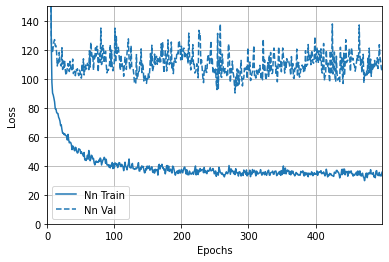

In [14]:
matplotlib.pyplot.ylim(0,150)
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot({'nn':history})

In [15]:
pred_ages = nn_model.predict(test).flatten()
mae = np.median(np.abs(pred_ages - test_ages))
mse = np.mean((pred_ages - val_ages)**2)
print('MAE: '+ str(mae))
print('MSE: '+ str(mse))

18/18 [==============================] - 0s 2ms/step
MAE: 3.416403674633788
MSE: 682.7493693934682


In [16]:
mae = np.mean(np.abs(pred_ages - test_ages))
mae

5.628869553573289

In [17]:
%tensorboard --logdir /gdrive/MyDrive/Altum_Age_Dataset/transformer_1024_log/

UsageError: Line magic function `%tensorboard` not found.


In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /gdrive/MyDrive/Altum_Age_Dataset/lightning_logs_4_head/

In [20]:
torch.save(nn_model, '/gdrive/MyDrive/MLP/1024mlp.pt')

In [ ]:
from datetime import datetime
today = datetime.today().strftime('%Y-%m-%d')
torch.save(model, f"/gdrive/MyDrive/Altum_Age_Dataset/{today}_transformer.pt")